In [1]:
import os
import cv2
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, MaxPooling2D, Conv2D
#

In [5]:
# 1 Téléchargement des images

def parsePath(input_file):
    with(open(input_file, 'r') as f):
        path = f.readline()
    return(path)

path = parsePath("C:\CodingProjects\Centrale Supelec\Predict damaged metal\path\chemin.txt")

img_data_withDef = []
img_data_withoutDef = []

path_img_with_def = path+"/with_default/"
path_img_without_def = path+"/without_default/"

directory_img_with_def = os.listdir(path_img_with_def)
directory_img_without_def = os.listdir(path_img_without_def)

nb_images = 500

directory_img_without_def = random.sample(directory_img_without_def, nb_images) 

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    zoom_range=[0.8, 1.2]
)

print("Chargement des images avec defaut ")
for filename in tqdm(directory_img_with_def):
    img = cv2.imread(path_img_with_def+filename) 
    img_array = np.array(img)
    img_data_withDef.append(img_array)

    
    for i in range(4) :
        img_aug = datagen.random_transform(img)
        #img_aug_grey = cv2.cvtColor(img_aug, cv2.COLOR_BGR2GRAY)
        img_aug_array = np.array(img_aug)
        img_data_withDef.append(img_aug_array)
print()

print("Chargement des images sans defaut ")
for filename in tqdm(directory_img_without_def):
    img = cv2.imread(path_img_without_def+filename) 
    img_array = np.array(img)
    img_data_withoutDef.append(img_array)    

print("\nNombre d'images avec défauts: ", len(img_data_withDef))
print("Nombre d'images sans défauts: ", len(img_data_withoutDef))

Chargement des images avec defaut 


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:30<00:00,  3.32it/s]



Chargement des images sans defaut 


100%|██████████| 500/500 [00:04<00:00, 103.36it/s]


Nombre d'images avec défauts:  500
Nombre d'images sans défauts:  500


In [6]:
# Labellisation

labels_with_defaults = [1] * len(img_data_withDef)

labels_without_default = [0] * len(img_data_withoutDef)

X = np.concatenate((img_data_withDef, img_data_withoutDef), axis=0)
y = np.concatenate((labels_with_defaults, labels_without_default), axis=0)

In [7]:
# 3 Pré-traitement

# Conversion en niveau de gris
print("Conversion en niveau de gris des images avec defaut")
img_data_withDef_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in tqdm(img_data_withDef)]
print("Conversion en niveau de gris des images sans defaut")
img_data_withoutDef_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in tqdm(img_data_withoutDef)]
print()

# Redimensionner les images en (32,32)
print("Redimensionnement des images avec defaut en (32,32)")
img_data_withDef_resized = [cv2.resize(img, (32, 32)) for img in tqdm(img_data_withDef_gray)]
print("Redimensionnement des images sans defaut en (32,32)")
img_data_withoutDef_resized = [cv2.resize(img, (32, 32)) for img in tqdm(img_data_withoutDef_gray)]
print()

# Aplatir les images en un vecteur de dimension (32x32)
print("Applatissement des images avec defaut")
img_data_withDef_flat = [np.array(img).flatten() for img in tqdm(img_data_withDef_resized)]
print("Applatissement des images sans defaut")
img_data_withoutDef_flat = [np.array(img).flatten() for img in tqdm(img_data_withoutDef_resized)]
print()

# Concaténer les données en étiquettes en une seule variable
X = np.concatenate((img_data_withDef_flat, img_data_withoutDef_flat), axis=0)
y = np.concatenate((labels_with_defaults, labels_without_default), axis=0)

print("shape de X", X.shape)
print("Shape de y", y.shape)

Conversion en niveau de gris des images avec defaut


100%|██████████| 500/500 [00:00<00:00, 887.52it/s] 


Conversion en niveau de gris des images sans defaut


100%|██████████| 500/500 [00:00<00:00, 1385.24it/s]



Redimensionnement des images avec defaut en (32,32)


100%|██████████| 500/500 [00:00<00:00, 18098.71it/s]


Redimensionnement des images sans defaut en (32,32)


100%|██████████| 500/500 [00:00<00:00, 65110.75it/s]



Applatissement des images avec defaut


100%|██████████| 500/500 [00:00<00:00, 115158.53it/s]


Applatissement des images sans defaut


100%|██████████| 500/500 [00:00<00:00, 214148.06it/s]



shape de X (1000, 1024)
Shape de y (1000,)


In [8]:
# 4 ACP

pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)

In [9]:
# 6 Application de l'algorithme

                    # Avant ACP

# Diviser les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un classifieur Random Forst avec 100 arbres
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrainer le classifieur sur les données d'entraînement
rf_classifier.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = rf_classifier.predict(X_test)

# Calculer la précision du modèle
accuracy = accuracy_score(y_test, y_pred) # Dans le cas d'une classification binaire, accuracy_score est utile car cette metrique fournit une mesure simple et facilement interprétable de la performance du modèle
print("Précision:", round(accuracy,2)*100,"%")

Précision: 91.0 %


In [10]:
# Application de l'algorithme

                    # Après ACP

# Diviser les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Créer un classifieur Random Forst avec 100 arbres
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrainer le classifieur sur les données d'entraînement
rf_classifier.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = rf_classifier.predict(X_test)

# Calculer la précision du modèle
accuracy = accuracy_score(y_test, y_pred) # Dans le cas d'une classification binaire, accuracy_score est utile car cette metrique fournit une mesure simple et facilement interprétable de la performance du modèle
print("Précision:", round(accuracy,2)*100,"%")

Précision: 92.0 %


Image avec défaut :
[1]
	La pièce est défectueuse


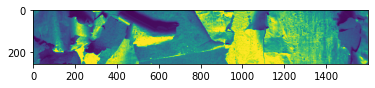


Image sans défaut :
[0]
	La pièce n'est pas défectueuse


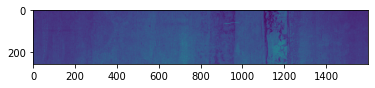

In [11]:
 # 8 Utiliser ce modèle afin de prédire si un métal est defectueux ou non

def predictACP(img) :
    img_resized = cv2.resize(img, (32, 32))
    img_flat = np.array(img_resized).flatten()
    img_pca = pca.transform([img_flat])
    return rf_classifier.predict(img_pca)

def printClass(label) :
    if label == 1:
        print("\tLa pièce est défectueuse")
    else:
        print("\tLa pièce n'est pas défectueuse")


imgDef = cv2.imread(path+"\with_default\\0a5a82b86.jpg", cv2.IMREAD_GRAYSCALE)
imgNoDef = cv2.imread(path+"\without_default\\0a4ef8ee7.jpg", cv2.IMREAD_GRAYSCALE)

print("Image avec défaut :")
labelDef = predictACP(imgDef)
print(labelDef)
printClass(labelDef)

plt.imshow(imgDef)
plt.show()
print("")


print("Image sans défaut :")
labelNoDef = predictACP(imgNoDef)
print(labelNoDef)
printClass(labelNoDef)
plt.imshow(imgNoDef)
plt.show()

In [12]:

# 9 Créer un réseau de neurone convolutif

def model():
    
    model = Sequential()

    # Première couche de convolution
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(32,32,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Deuxième couche de convolution 
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Troisième couche de convolution
    model.add(Conv2D(128, (3,3,), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Couche de flattening
    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compilation du modèle
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

    return model

model_sample = model()

In [13]:
# Training phase

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

history = model_sample.fit(X_train, y_train, batch_size=32, epochs=15, validation_data=(X_test, y_test))

score = model_sample.evaluate(X_test, y_test, verbose=0)
print('Perte:', round(score[0],2))
print('Précision:', round(score[1],3)*100,'%')


Epoch 1/15
25/25 [==============================] - 1s 19ms/step - loss: 0.6351 - accuracy: 0.5625 - val_loss: 0.5988 - val_accuracy: 0.6900
Epoch 2/15
25/25 [==============================] - 0s 12ms/step - loss: 0.5512 - accuracy: 0.7163 - val_loss: 0.5527 - val_accuracy: 0.6700
Epoch 3/15
25/25 [==============================] - 0s 13ms/step - loss: 0.4377 - accuracy: 0.7812 - val_loss: 0.4046 - val_accuracy: 0.7950
Epoch 4/15
25/25 [==============================] - 0s 13ms/step - loss: 0.4152 - accuracy: 0.7713 - val_loss: 0.3885 - val_accuracy: 0.7850
Epoch 5/15
25/25 [==============================] - 0s 12ms/step - loss: 0.3284 - accuracy: 0.8263 - val_loss: 0.3035 - val_accuracy: 0.8600
Epoch 6/15
25/25 [==============================] - 0s 12ms/step - loss: 0.2612 - accuracy: 0.8850 - val_loss: 0.2613 - val_accuracy: 0.9100
Epoch 7/15
25/25 [==============================] - 0s 12ms/step - loss: 0.2883 - accuracy: 0.8813 - val_loss: 0.3360 - val_accuracy: 0.8600
Epoch 8/15
25

0.9350000023841858


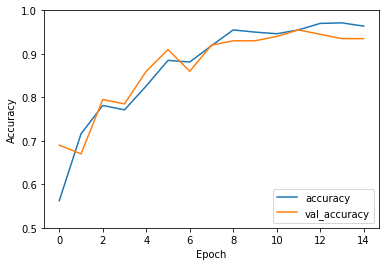

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model_sample.evaluate(X_test,y_test,verbose=0)

print(test_acc)

1/1 [==============================] - 0s 87ms/step
[[0.9969677]]
Classe : 1
Métal défectueux


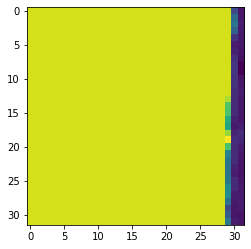

1/1 [==============================] - 0s 18ms/step
[[0.90979433]]
Classe : 0
Métal défectueux


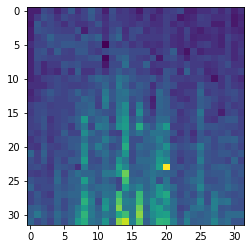

1/1 [==============================] - 0s 16ms/step
[[0.00321988]]
Classe : 0
Métal non defectueux


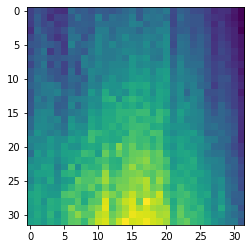

1/1 [==============================] - 0s 15ms/step
[[0.00753869]]
Classe : 0
Métal non defectueux


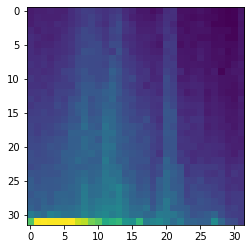

1/1 [==============================] - 0s 16ms/step
[[0.00380841]]
Classe : 0
Métal non defectueux


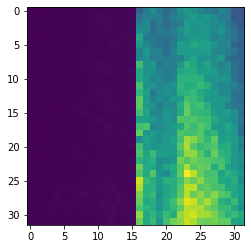

1/1 [==============================] - 0s 16ms/step
[[0.0136094]]
Classe : 0
Métal non defectueux


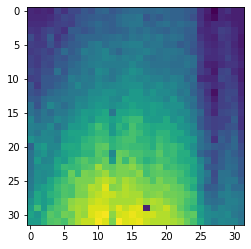

1/1 [==============================] - 0s 16ms/step
[[1.]]
Classe : 1
Métal défectueux


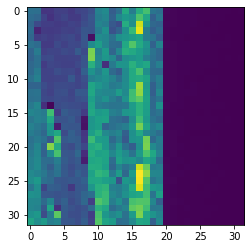

1/1 [==============================] - 0s 15ms/step
[[0.75533986]]
Classe : 0
Métal défectueux


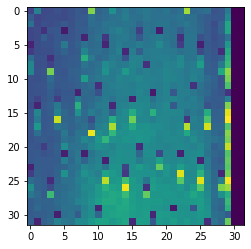

1/1 [==============================] - 0s 16ms/step
[[1.]]
Classe : 1
Métal défectueux


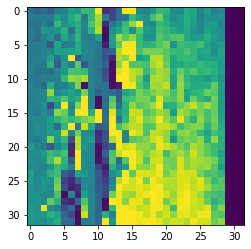

1/1 [==============================] - 0s 17ms/step
[[0.01216826]]
Classe : 0
Métal non defectueux


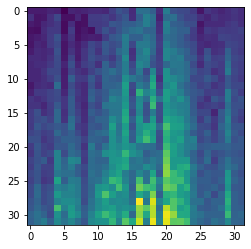

1/1 [==============================] - 0s 15ms/step
[[0.99953806]]
Classe : 1
Métal défectueux


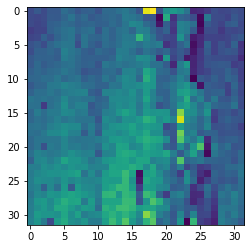

1/1 [==============================] - 0s 15ms/step
[[0.9999994]]
Classe : 1
Métal défectueux


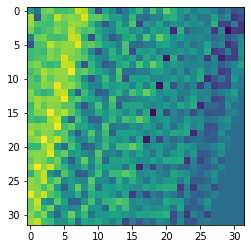

1/1 [==============================] - 0s 16ms/step
[[0.01151788]]
Classe : 0
Métal non defectueux


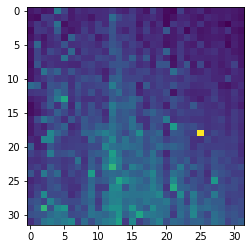

1/1 [==============================] - 0s 16ms/step
[[0.00363712]]
Classe : 0
Métal non defectueux


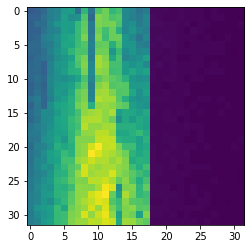

1/1 [==============================] - 0s 16ms/step
[[0.00105348]]
Classe : 0
Métal non defectueux


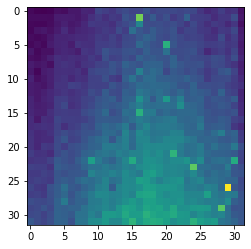

1/1 [==============================] - 0s 16ms/step
[[0.9939356]]
Classe : 1
Métal défectueux


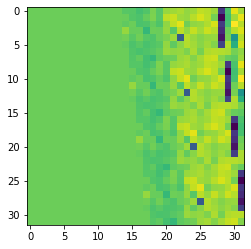

1/1 [==============================] - 0s 17ms/step
[[0.00095784]]
Classe : 0
Métal non defectueux


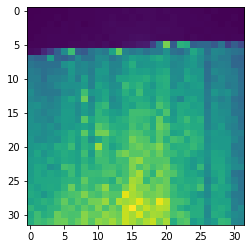

1/1 [==============================] - 0s 17ms/step
[[1.]]
Classe : 1
Métal défectueux


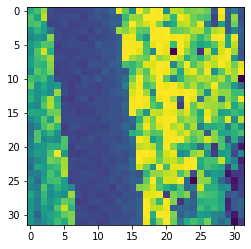

1/1 [==============================] - 0s 20ms/step
[[0.00497412]]
Classe : 0
Métal non defectueux


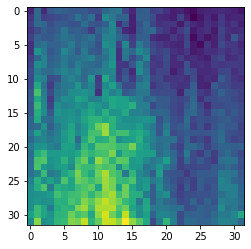

1/1 [==============================] - 0s 16ms/step
[[0.03935194]]
Classe : 0
Métal non defectueux


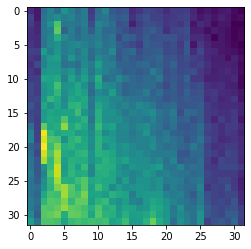

1/1 [==============================] - 0s 18ms/step
[[1.]]
Classe : 1
Métal défectueux


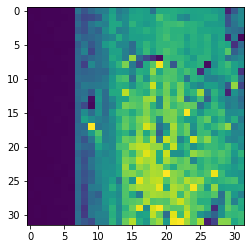

1/1 [==============================] - 0s 17ms/step
[[0.00531171]]
Classe : 0
Métal non defectueux


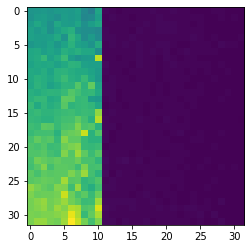

1/1 [==============================] - 0s 16ms/step
[[0.00468953]]
Classe : 0
Métal non defectueux


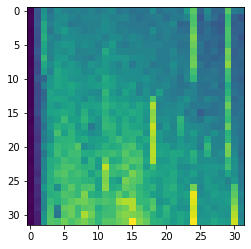

1/1 [==============================] - 0s 16ms/step
[[1.]]
Classe : 1
Métal défectueux


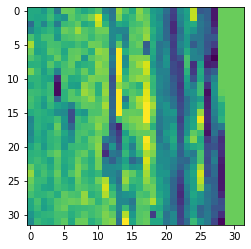

1/1 [==============================] - 0s 17ms/step
[[0.05571172]]
Classe : 0
Métal non defectueux


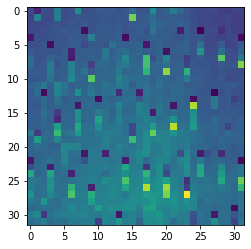

1/1 [==============================] - 0s 26ms/step
[[0.99999094]]
Classe : 1
Métal défectueux


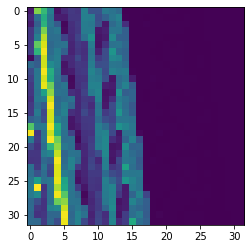

1/1 [==============================] - 0s 18ms/step
[[0.09414472]]
Classe : 0
Métal non defectueux


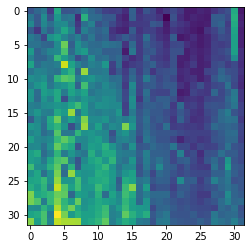

1/1 [==============================] - 0s 18ms/step
[[0.9999999]]
Classe : 1
Métal défectueux


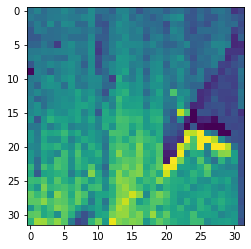

1/1 [==============================] - 0s 17ms/step
[[0.28026646]]
Classe : 0
Métal non defectueux


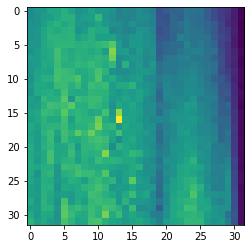

1/1 [==============================] - 0s 18ms/step
[[0.00980178]]
Classe : 0
Métal non defectueux


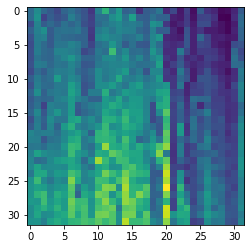

In [15]:
# 12 Utiliser ce réseau afin de prédire si un métal est défectueux ou non

nb_images_test = 30

for i, img in enumerate(X_train):
    
    if(i == nb_images_test) :
        break
    
    img = resize(img, (32,32))
    plt.show()
    imgPred = np.expand_dims(img, axis=0)
    pred = model_sample.predict(imgPred)

    print(pred)
    print("Classe : " +str(y_train[i]))
    if(pred[0] > 0.5):
        print("Métal défectueux")
    else:
        print("Métal non defectueux")

    plt.imshow(np.asarray(img))
